# Markov Decison Processes

In Markov Decision Processes, one's actions affect the state of the world.  

Given a state $s$ and an action $a$, we know the probability it will end up in the next state $s'$ 

## Value Iteration/Backwards Induction/Dynamic Programming

Value iteration estimates the value of the best action at each state, $V^*(s)$, with recursion since

$$V^*(s) = \max_a\sum_{s'}P(s'|s,a)\left(R(s,a,s') + \gamma V^*(s')\right)$$

This equation is also known as the Bellman equation

Because of the discount factor, $\gamma$, our estimates will converge with the number of iterations since 

$$\mid V^*_i(s) - V^*_{i+1}(s) \mid  \leq \gamma^i\mid R_{max} - R_{min}\mid$$ 


## Gridworld Toy Example

Gridworld, a typical Reinforcement Learning problem, requires the agent to navigate to a goal loation and avoid possible pitfalls

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

sns.set_context('poster')
sns.set_palette('colorblind')

%matplotlib inline

### Let's imagine a 3 by 4 grid with 1 goal and 1 pitfall

In [3]:
grid = np.array([[-.01,-.01,-.01,1],[-.01,np.nan, -.01, -1],[-.01,-.01,-.01,-.01]])

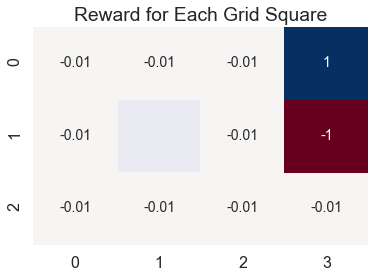

In [4]:
sns.heatmap(grid, cmap='RdBu', annot=True, cbar = False, annot_kws={"size": 14})
plt.title('Reward for Each Grid Square')

## In this world the agent can go up, down, left and right

### We'll assume 90% of the time the agent ends up going where it wants to go

### 10% of the time it veers off perpendicularly

### If it ends up in the pitfall or the goal, it's in the `exit` state and the game is over

In [5]:
actions = ['up', 'down', 'left', 'right']
transition = pd.DataFrame(np.array([[.9, 0, .05, .05,], [0, .9, .05, .05], [.05, .05, .9, 0],
                                    [.05, .05, 0, .9]]), index = actions, columns = actions)

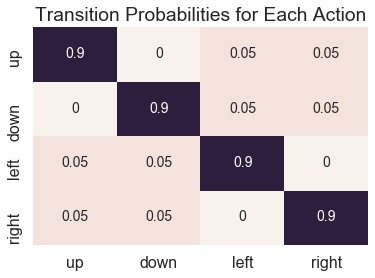

In [6]:
sns.heatmap(transition, annot=True, cbar = False, annot_kws={"size": 14})
plt.title('Transition Probabilities for Each Action')

Right now our policy is unknown

In [7]:
policy = pd.DataFrame([['unknown', 'unknown', 'unknown', 'exit'],
                       ['unknown', '', 'unknown', 'exit'],
                       ['unknown', 'unknown', 'unknown', 'unknown']])

In [8]:
policy

,0,1,2,3
0,unknown,unknown,unknown,exit
1,unknown,,unknown,exit
2,unknown,unknown,unknown,unknown


## We'll now use Value Iteration to Solve for the Optimal Policy

Assume the discount factor is $0.75$

Let's set up our function to update the Q-values

In [9]:
gamma = 0.75
row, col = np.shape(grid)
nactions = len(actions)

q_values = np.zeros((row,col,nactions))
v_values = np.copy(grid)

def index_grid(r, c, action):
    '''
    finds the right index for the next state based on the action name
    if the agent tries to go in the direction of a wall or edge,
    the agent says in the same place
    
    Args:
        r: row
        c: column
        action: action name
    
    Returns:
        r: updated row
        c: updated column
    '''
    if  action == 'up':
        if r > 0:
            r -= 1
    if action == 'down':
        if r < row - 1:
            r += 1
    if action == 'left':
        if c > 0:
            c -= 1
    if action == 'right':
        if c < col - 1:
            c += 1
    return r, c

def update_q(qvalues, vvalues):
    '''
    updates the value of each action given the current state and possible future states
    recall that the value of each action is the expected value of the current action 
    + future scenarios (see bellman equation above)
    
    Args:
        qvalues: array of qvalues for each state, action pair
        vvalues: array of vvalues for each state
    
    Returns:
        qvalues: updated qvalues
    '''
    for r in range(row):
        for c in range(col):
            #if we are in the exit squares, there is no where else to go so the value is fixed
            if abs(v_values[r, c]) == 1:
                qvalues[r, c, :] = v_values[r, c]
                continue
            #if we're in a nan square we can assume there's no value for that state
            elif np.isnan(grid[r, c]):
                qvalues[r, c, :] = np.nan
            for i, s in enumerate(actions):
                #we're going to loop over the actions twice because we're going from one state to another
                rewards = np.zeros(len(actions))
                for s_prime in range(len(rewards)):
                    #transitions with 0 probabiliy we can ignore
                    if transition[s].ix[actions[s_prime]] == 0:
                        continue
                    nrow, ncol = index_grid(r,c,s)
                    #attempts to go to the empty square result on the agent staying put
                    if np.isnan(grid[nrow, ncol]):
                        rewards[s_prime] = grid[r, c] + gamma*vvalues[r, c]
                    else:
                        rewards[s_prime] = grid[r, c] + gamma*vvalues[nrow, ncol]
                expected_value = np.dot(rewards, np.squeeze(transition[s]))
                qvalues[r,c,i] = expected_value
    return qvalues

## Now let's update the Q-values based on what we see on the grid

In [10]:
qvalues_1 = update_q(q_values, v_values)
qvalues_1

/Users/4d/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:64: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


array([[[-0.0175, -0.0175, -0.0175, -0.0175],
        [-0.0175, -0.0175, -0.0175, -0.0175],
        [-0.0175, -0.0175, -0.0175,  0.74  ],
        [ 1.    ,  1.    ,  1.    ,  1.    ]],

       [[-0.0175, -0.0175, -0.0175, -0.0175],
        [    nan,     nan,     nan,     nan],
        [-0.0175, -0.0175, -0.0175, -0.76  ],
        [-1.    , -1.    , -1.    , -1.    ]],

       [[-0.0175, -0.0175, -0.0175, -0.0175],
        [-0.0175, -0.0175, -0.0175, -0.0175],
        [-0.0175, -0.0175, -0.0175, -0.0175],
        [-0.76  , -0.0175, -0.0175, -0.0175]]])

## Once we know these Q-values we can update the V-values

Recall that 

$$V^*(s) = \max(Q^*(s,a))$$

and the optimal policy, $\pi^*(s)$, is

$$\pi^*(s) = \text{argmax}(Q^*(s,a))$$

In [11]:
def update_v(qvalues, policy):
    '''
    updates the policy based on the qvalues
    recall that v*(s) = max(q*(s,a))
    also pi*(s) = argmax(q*(s,a))
    
    Args:
        qvalues: array of values for each state, action pair
        policy: array of actions for each state
    
    Returns:
        v_values_new: new array vvalues for each state
        policy: updated policy array
    '''
    v_values_new = np.max(qvalues, axis = 2)
    policy_indices = np.argmax(qvalues, axis = 2)
    for r in policy.index:
        for c in policy.columns:
            #we can ignore the blank states and terminal states
            if policy[c].ix[r] == 'exit' or policy[c].ix[r] == '':
                continue
            policy[c].ix[r] = actions[policy_indices[r, c]]
    return v_values_new, policy

/Users/4d/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


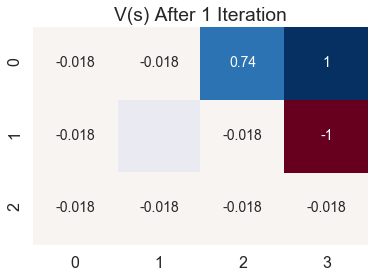

In [12]:
vvalues_1, policy_1 = update_v(qvalues_1, policy)
sns.heatmap(vvalues_1, cmap='RdBu', annot=True, cbar = False, annot_kws={"size": 14})
plt.title('V(s) After 1 Iteration')

In [13]:
policy_1

,0,1,2,3
0,up,up,right,exit
1,up,,up,exit
2,up,up,up,down


# Now let's run this one more time to see how these values change again

In [14]:
qvalues_2 = update_q(qvalues_1, vvalues_1)
qvalues_2

array([[[-0.023125, -0.023125, -0.023125, -0.023125],
        [-0.023125, -0.023125, -0.023125,  0.545   ],
        [ 0.545   , -0.023125, -0.023125,  0.74    ],
        [ 1.      ,  1.      ,  1.      ,  1.      ]],

       [[-0.023125, -0.023125, -0.023125, -0.023125],
        [      nan,       nan,       nan,       nan],
        [ 0.545   , -0.023125, -0.023125, -0.76    ],
        [-1.      , -1.      , -1.      , -1.      ]],

       [[-0.023125, -0.023125, -0.023125, -0.023125],
        [-0.023125, -0.023125, -0.023125, -0.023125],
        [-0.023125, -0.023125, -0.023125, -0.023125],
        [-0.76    , -0.023125, -0.023125, -0.023125]]])

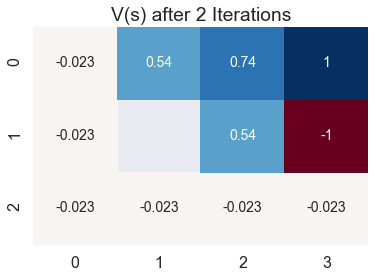

In [15]:
vvalues_2, policy_2 = update_v(qvalues_2, policy_1)
sns.heatmap(vvalues_2, cmap='RdBu', annot=True, cbar = False, annot_kws={"size": 14})
plt.title('V(s) after 2 Iterations')

In [16]:
policy_2

,0,1,2,3
0,up,right,right,exit
1,up,,up,exit
2,up,up,up,down


# We can now combine these two steps and run until convergence

In [17]:
def value_iteration(qvalues, vvalues, policy, epsilon):
    qvalues = update_q(qvalues, vvalues)
    v_new, policy_new = update_v(qvalues, policy)  
    print(abs(v_new - vvalues))
    while (np.nanmax(abs(v_new - vvalues)) > epsilon):
        print('current epsilon: %0.5f' % np.nanmax(abs(v_new - vvalues)))
        vvalues = v_new
        qvalues = update_q(qvalues, vvalues)
        v_new, policy_new = update_v(qvalues, policy)
        
    return v_new, policy_new, qvalues

In [18]:
v_final, policy_final, qvalues = value_iteration(qvalues_2, vvalues_2, policy_2, 0.001)

[[ 0.421875    0.          0.          0.        ]
 [ 0.00421875         nan  0.          0.        ]
 [ 0.00421875  0.00421875  0.421875    0.00421875]]
current epsilon: 0.42187
current epsilon: 0.31641
current epsilon: 0.23730


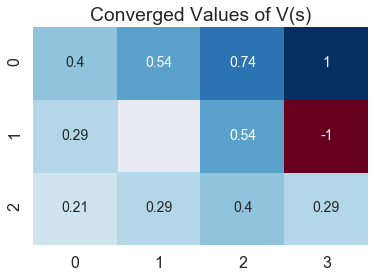

In [19]:
sns.heatmap(v_final, cmap='RdBu', annot=True, cbar = False, annot_kws={"size": 14})
plt.title('Converged Values of V(s)')

## Why are these our V values?

1. Discount factor for future reward ($\gamma$)
2. Small negative value of most squares (-0.01)
3. Large negative value of one square (-1)
4. Veering off course 5% of time into undesirable squares

In [20]:
policy_final

,0,1,2,3
0,right,right,right,exit
1,up,,up,exit
2,up,right,up,left


In [21]:
qvalues.argmax(-1)

array([[3, 3, 3, 0],
       [0, 0, 0, 0],
       [0, 3, 0, 2]])

# But what if you can't do dynamic programming?


## Dynamic Programming requires the transition probabilities between states to be known

## How can we estimate $Q(s,a)$ without a model of these transitions?

---



# SARSA is both model-free and on-policy

SARSA: State, Action, Reward, State, Action

Model-free: no need to know transition probabilities

On-Policy: Estimates Q-values based on the action of the current policy


---


# Remember $$Q(s,a)=\sum_{s'}P(s'|s,a)\left(R(s,a,s') + \gamma V^*(s')\right)$$


Which is the average reward of taking action $a$ when you're in state $s$ and following the optimal policy from there

###  Why can't we make an update equation for our estimates of $Q(s,a)$ based on our experiences with the environment?


# With update $\alpha$, we get an exponentially weighted average of $Q(s,a)$



# $$Q(s,a) \leftarrow Q(s,a) + \alpha\big[r+\gamma Q(s',a') - Q(s,a)\big]$$


---

## Let's redo this with SARSA

In [22]:
gamma = .99
start = [2,0]
epsilon = .1
nactions = len(actions)
q_values = np.zeros(np.shape(grid) + (nactions,))
q_value_observations = np.zeros(np.shape(grid) + (nactions,))
epsilon = 0.1

In [23]:
def update_policy_frame(policy_frame, policy):
    for r in range(row):
        for c in range(col):
            if np.isfinite(policy[r,c]):
                policy_frame[c].ix[r] = actions[int(policy[r,c])]
    return policy_frame


def epsilon_greedy(r, c, grid, pol, e=epsilon):
    if abs(grid[r,c]) == 1:
        return np.nan
    elif grid[r, c] == -0.01:
        flip = bool(np.random.binomial(1, e, size=None))
        if flip:
            new_choice = np.random.choice(list(range(nactions))) 
            return new_choice      
        else:
            return pol[r,c]
    else:
        return np.nan
    
def get_next_state(action):
    return np.random.choice(list(range(nactions)), p=np.squeeze(transition[actions[action]])) 

def update_policy(qvalues, pol):
    '''
    updates the policy based on the qvalues
    recall that v*(s) = max(q*(s,a))
    also pi*(s) = argmax(q*(s,a))
    '''
    pol_indices = np.nanargmax(qvalues, axis = 2)
    pol_indices = pol_indices.astype(float)
    pol_indices[1,1] = np.nan
    pol_indices[0,3] = np.nan
    pol_indices[1,3] = np.nan
    return pol_indices

def sarsa_equation(qv, old_tuple, a, r, g, new_tuple):
    q_k = qv[old_tuple]
    update = q_k + a * (r + g * qv[new_tuple] - q_k)
    return update

def sarsa_update(r, c, action, alpha, grid, pol):
    action = int(action)
    viz = np.zeros((row, col))
    viz[r, c] += 1  
    old = (r, c, action)
    noisy_action = get_next_state(action)
    r_prime, c_prime = index_grid(r, c, actions[noisy_action])
    #pdb.set_trace()
    if (r_prime == 1) and (c_prime == 1):
        r_prime = r
        c_prime = c
    viz[r_prime, c_prime] += 2
    #print(viz)
    reward = grid[r, c]
    action_prime = epsilon_greedy(r_prime, c_prime, grid, pol)
    if np.isfinite(action_prime):
        action_prime = int(action_prime)
        #print(("next action is action %d: %s" % (action_prime, actions[action_prime])))
        #print(('current q_value is %.2f' % q_k))
        #print(('next q_value is  %.2f' % q_values[r_prime, c_prime, action_prime]))
        #'q(s,a) += alpha*(r(s,a,s_prime) + gamma*q(s_prime, a_prime) - q(s,a))'
        #if (r_prime == r and c_prime == c) and q_k != 0:
            #pdb.set_trace()
        #q_update = q_k + alpha * (reward + gamma * q_values[r_prime, c_prime, action_prime] - q_k)
        new = (r_prime, c_prime, action_prime)
        
    else:
        #pdb.set_trace()
        #q_update = q_k + alpha * (reward + gamma * q_values[r_prime, c_prime, 0] - q_k)
        new = (r_prime, c_prime,0)
        
    q_update = sarsa_equation(q_values, old, alpha, reward, gamma, new)
        
    if q_update > 1: #or q_update != -0.01:
        pdb.set_trace()
    return q_update, r_prime, c_prime, action_prime

def experiment(alpha, grid, pol, epsilon):
    n_moves = 0
    total_reward = 0 
    r, c = int(start[0]), int(start[1])
    action = int(epsilon_greedy(r,c, grid, pol, epsilon))
    while np.isfinite(action):
        #print(("at row %d column %d taking action %d: %s" % (r, c, action, actions[action])))
        #print(('action is %d' % action))
        #print('policy is')
        #print(pol)
        #print('running sarsa update')
        q_value_observations[r,c,action] += 1
        q_update, r_prime, c_prime, action_prime = sarsa_update(r, c, action, alpha, grid, pol)
        #print('q_update is %0.2f' % q_update)
        q_values[r, c, action] = q_update
        new_policy = update_policy(q_values, pol)
        #print('policy is') 
        #print(pol)
        #print() 
        #print('new policy is')
        #print(new_policy) 
        pol = new_policy
        #print('policy is now')
        #print(pol)
        r = r_prime
        c = c_prime
        action = action_prime
        n_moves += 1
        total_reward += grid[r, c]
        #print() 
        #print(q_values)
        #pdb.set_trace()
    if grid[r, c] == 1:
        print('terminating at goal')
        q_values[r, c, :] = grid[r,c]
    elif grid[r,c] == -1:
        print('terminating at pit')
        q_values[r,c, :] += alpha * (grid[r,c] - q_values[r,c, :])
    else:
        print(r) 
        print(c)
        #pdb.set_trace()
    
    return pol, n_moves, total_reward, grid[r,c] == 1

In [24]:
sarsa_pol = q_values.argmax(-1).astype(float)
sarsa_frame = pd.DataFrame([['unknown', 'unknown', 'unknown', 'exit'],
                       ['unknown', '', 'unknown', 'exit'],
                       ['unknown', 'unknown', 'unknown', 'unknown']])
n_experiments = 200
sarsa_results = pd.DataFrame(index=(range(n_experiments)), columns=['moves', 'total_reward', 'hit_goal', 'epsilon'])

for i in range(n_experiments):
    print('experiment %d' % i)
    alpha = 0.5
    sarsa_pol, total_moves, total_reward, hit_goal = experiment(alpha, grid, sarsa_pol, epsilon)
    sarsa_frame = update_policy_frame(sarsa_frame, sarsa_pol)
    sarsa_results.ix[i] = pd.Series(data=[total_moves, total_reward, hit_goal, epsilon],
                                    index=list(sarsa_results.columns))
    epsilon = 1./((i/50) + 10)
    #print policy_frame
    #print

experiment 0
terminating at pit
experiment 1
terminating at pit
experiment 2
terminating at pit
experiment 3
terminating at goal
experiment 4
terminating at goal
experiment 5

/Users/4d/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Users/4d/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



terminating at goal
experiment 6
terminating at goal
experiment 7
terminating at goal
experiment 8
terminating at pit
experiment 9
terminating at pit
experiment 10
terminating at goal
experiment 11
terminating at goal
experiment 12
terminating at goal
experiment 13
terminating at goal
experiment 14
terminating at goal
experiment 15
terminating at goal
experiment 16
terminating at pit
experiment 17
terminating at goal
experiment 18
terminating at goal
experiment 19
terminating at pit
experiment 20
terminating at goal
experiment 21
terminating at goal
experiment 22
terminating at goal
experiment 23
terminating at goal
experiment 24
terminating at pit
experiment 25
terminating at goal
experiment 26
terminating at goal
experiment 27
terminating at goal
experiment 28
terminating at goal
experiment 29
terminating at goal
experiment 30
terminating at goal
experiment 31
terminating at goal
experiment 32
terminating at goal
experiment 33
terminating at goal
experiment 34
terminating at goal
ex

In [25]:
sarsa_frame

,0,1,2,3
0,right,right,right,exit
1,up,,up,exit
2,up,left,left,left


In [26]:
q_values

array([[[ 0.75106961,  0.61561459,  0.6187755 ,  0.9343598 ],
        [ 0.57945488,  0.59953239,  0.62718656,  0.90632845],
        [ 0.57226626,  0.46494454,  0.6524835 ,  0.92729387],
        [ 1.        ,  1.        ,  1.        ,  1.        ]],

       [[ 0.8848373 ,  0.63224456,  0.60958037,  0.7056146 ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.66286733, -0.48455184, -0.07104703, -0.80442383],
        [-0.99993896, -0.99993896, -0.99993896, -0.99993896]],

       [[ 0.78673026,  0.59307239,  0.66826556,  0.50074286],
        [ 0.34241292,  0.28570449,  0.67207065,  0.43180827],
        [-0.03358615, -0.02857891,  0.3710103 , -0.04196928],
        [-0.68925415, -0.14978831, -0.03843734, -0.12305785]]])

In [27]:
q_value_observations

array([[[  39.,   75.,   41.,  181.],
        [  43.,    6.,   14.,  190.],
        [  33.,    5.,   23.,  202.],
        [   0.,    0.,    0.,    0.]],

       [[ 226.,   54.,   72.,  137.],
        [   0.,    0.,    0.,    0.],
        [  62.,   39.,   28.,    3.],
        [   0.,    0.,    0.,    0.]],

       [[ 227.,   50.,   62.,   68.],
        [  22.,   10.,   25.,   68.],
        [ 100.,    9.,    6.,   18.],
        [   3.,   20.,   17.,   19.]]])

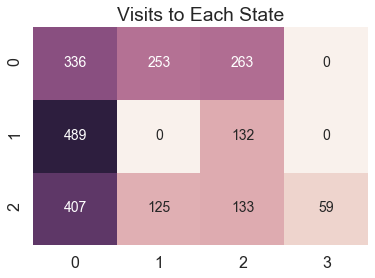

In [28]:
sns.heatmap(q_value_observations.sum(-1), cbar=False, annot=True, fmt='.0f', annot_kws={"size": 14})
plt.title('Visits to Each State')

In [29]:
sarsa_results.tail()

,moves,total_reward,hit_goal,epsilon
195,8,0.93,True,0.0720461
196,6,0.95,True,0.0719424
197,7,0.94,True,0.0718391
198,11,0.9,True,0.071736
199,5,0.96,True,0.0716332


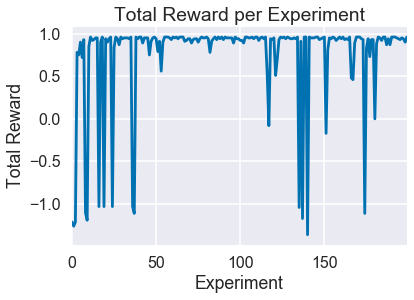

In [30]:
sarsa_results.total_reward.plot()
plt.title('Total Reward per Experiment')
plt.xlabel('Experiment')
plt.ylabel('Total Reward')

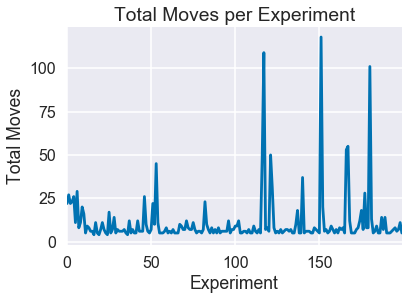

In [31]:
sarsa_results.moves.plot()
plt.title('Total Moves per Experiment')
plt.xlabel('Experiment')
plt.ylabel('Total Moves')

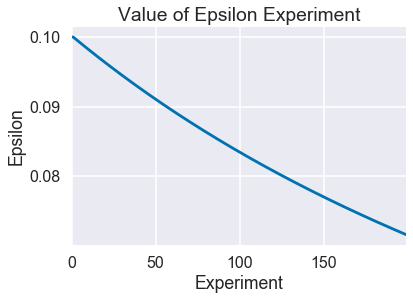

In [32]:
sarsa_results.epsilon.plot()
plt.title('Value of Epsilon Experiment')
plt.xlabel('Experiment')
plt.ylabel('Epsilon')

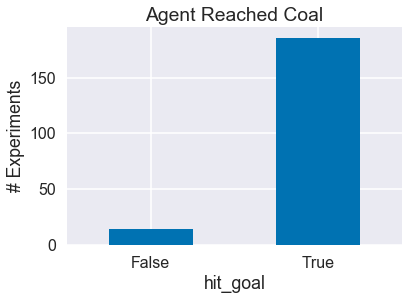

In [33]:
sarsa_results.groupby('hit_goal')['total_reward'].count().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Agent Reached Coal')
plt.ylabel('# Experiments')